# Part 2 — Detecting anomalies and change points in time series of Asian economic data

**Dataset:** `TSA_DATA02/Data02_02_Bangladesh_C.csv` (1990–2021)  
**Summary (≤ 50 words):** Detect anomalous observations and structural change points in economic indicators (ggdp, mil, inf, fdi, gdp) using Z-score, Isolation Forest, and change-point methods (ruptures). Present figures, anomaly tables, and a short interpretation for each variable.


In [18]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# for change point detection
try:
    import ruptures as rpt
    has_ruptures = True
except Exception as e:
    print("ruptures not available. Install with `pip install ruptures` if you want change point detection.")
    has_ruptures = False

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")


In [20]:
# Path to dataset (update if needed)
fn = "TSA_DATA_02/Data02_02_Bangladesh_C.csv"
df = pd.read_csv(fn)

# Ensure columns exist and normalize names
print("Initial columns:", df.columns.tolist())
df.columns = [c.strip() for c in df.columns]

# Show head and basic info
display(df.head(8))
print("\nShape:", df.shape)
print("\nMissing values per column:")
print(df.isna().sum())

# Map expected columns and types
expected_cols = ['year','country','ggdp','mil','inf','fdi','gdp']
for c in expected_cols:
    if c not in df.columns:
        raise ValueError(f"Expected column '{c}' not found in CSV.")

# set index to year (as int)
df['year'] = df['year'].astype(int)
df = df.set_index('year').sort_index()

# Keep only numeric series for detection
series_cols = ['ggdp','mil','inf','fdi','gdp']
df[series_cols] = df[series_cols].apply(pd.to_numeric, errors='coerce')

display(df[series_cols].head())


Initial columns: ['year', 'country', 'ggdp', 'mil', 'inf', 'fdi', 'gdp']


,year,country,ggdp,mil,inf,fdi,gdp
0,1990,Bangladesh,3.100000e+10,4.671441,6.126718,3.238781e+06,31598341233
1,1991,Bangladesh,3.100000e+10,4.338775,6.357364,1.390444e+06,30957483950
2,1992,Bangladesh,3.100000e+10,4.074295,3.634077,3.721853e+06,31708874594
3,1993,Bangladesh,3.300000e+10,4.055054,3.014819,1.404989e+07,33166519418
4,1994,Bangladesh,3.300000e+10,4.074397,5.313740,1.114779e+07,33768660883
5,1995,Bangladesh,3.800000e+10,NaN,10.297812,1.896372e+06,37939748769
6,1996,Bangladesh,4.600000e+10,1.223165,2.377129,1.352983e+07,46438484108
7,1997,Bangladesh,4.800000e+10,1.214423,5.305601,1.393762e+08,48244309133



Shape: (32, 7)

Missing values per column:
year       0
country    0
ggdp       2
mil        1
inf        0
fdi        1
gdp        0
dtype: int64


,ggdp,mil,inf,fdi,gdp
year,,,,,
1990,3.100000e+10,4.671441,6.126718,3.238781e+06,31598341233
1991,3.100000e+10,4.338775,6.357364,1.390444e+06,30957483950
1992,3.100000e+10,4.074295,3.634077,3.721853e+06,31708874594
1993,3.300000e+10,4.055054,3.014819,1.404989e+07,33166519418
1994,3.300000e+10,4.074397,5.313740,1.114779e+07,33768660883


## 2.1 Introduction

**Methodologies used**
- **Z-Score**: simple rule-based method (|Z| > 3 indicates anomaly). Good for large, isolated outliers.
- **Isolation Forest**: tree-based unsupervised model that isolates anomalies; handles skewed data better.
- **Change-point detection (ruptures)**: detects structural breaks (mean/variance shifts) in time series.

**Variables analysed**
- `ggdp` — Green Gross Domestic Product (USD)
- `mil`  — Military spending (as percent or ratio)
- `inf`  — Inflation rate (%)
- `fdi`  — Foreign Direct Investment (USD)
- `gdp`  — Gross Domestic Product (USD)

For each series: we will present Code → Result (plot/table) → Comment (short interpretation).


In [21]:
# Helper functions used across the notebook

def plot_series_with_anomalies(years, values, anomalies_idx=None, title=None, ylabel=None, figsize=(12,3)):
    plt.figure(figsize=figsize)
    plt.plot(years, values, marker='o', label='Value')
    if anomalies_idx is not None and len(anomalies_idx)>0:
        plt.scatter(years[anomalies_idx], values.iloc[anomalies_idx], color='red', s=80, label='Anomaly')
    plt.title(title or "")
    plt.xlabel("Year")
    plt.ylabel(ylabel or "Value")
    plt.grid(True)
    plt.legend()
    plt.show()

def detect_zscore_anomalies(series, threshold=3.0):
    """Return dataframe of anomalies with year, value, zscore and index positions."""
    s = series.dropna()
    mu = s.mean()
    sigma = s.std(ddof=0)
    z = (s - mu) / sigma
    mask = z.abs() > threshold
    anomalies = pd.DataFrame({'year': s.index[mask], 'value': s[mask], 'zscore': z[mask]})
    anomalies.index = anomalies['year']
    return anomalies, z

def detect_isolation_forest(series, contamination=0.1, random_state=RANDOM_STATE):
    """Return dataframe of anomalies (isolation forest)."""
    s = series.dropna()
    # reshape to 2D
    X = s.values.reshape(-1,1)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    iso.fit(Xs)
    preds = iso.predict(Xs)  # -1 for anomaly, 1 for normal
    mask = preds == -1
    anomalies = pd.DataFrame({'year': s.index[mask], 'value': s[mask]})
    anomalies.index = anomalies['year']
    return anomalies, preds, scaler

def detect_change_points(series, model="rbf", pen=10, n_bkps=None):
    """Use ruptures to detect change points. Returns list of change point years (indices).
       If ruptures not available returns empty list.
    """
    if not has_ruptures:
        return []
    s = series.dropna()
    # convert to numpy array for ruptures
    sig = s.values
    algo = rpt.Pelt(model=model).fit(sig)
    if n_bkps is not None:
        bkps = algo.predict(n_bkps=n_bkps)
    else:
        # try an absolute penalty; you can tune pen
        bkps = algo.predict(pen=pen)
    # bkps is list of ending indices (1-based) -> convert to years index (0-based)
    # bkps contains indices in [1..len(sig)]
    years = s.index.tolist()
    change_years = []
    for b in bkps:
        if b < 1 or b > len(years):
            continue
        year = years[b-1]
        change_years.append(year)
    # remove final bkps equal to last index (not a change point per se)
    if change_years and change_years[-1] == years[-1]:
        change_years = change_years[:-1]
    return change_years


## 2.2 A — Z-Score Method (threshold = 3)

For each series: compute Z-score and flag |Z| > 3. Plot and list anomalies (Year, Value, Z-score).



--- Z-Score anomalies for ggdp ---


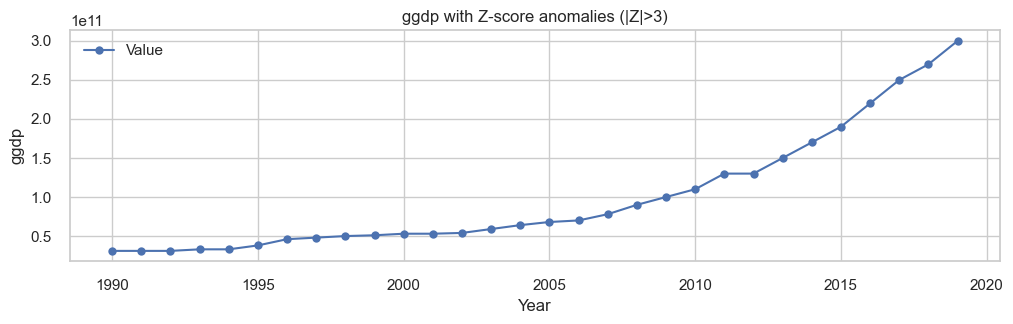

No anomalies detected by Z-score for this series.

--- Z-Score anomalies for mil ---


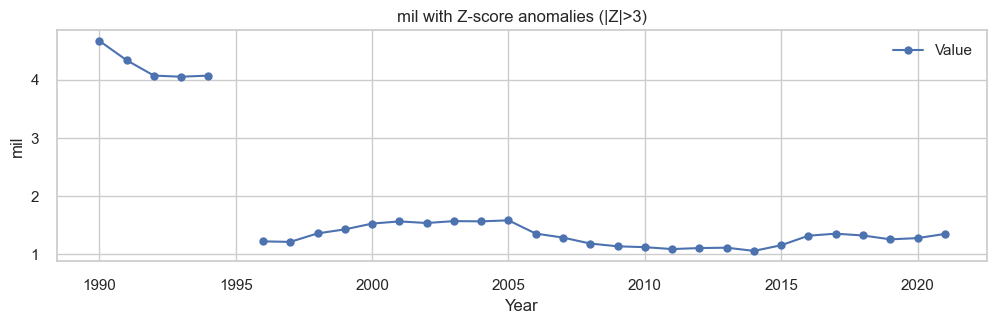

No anomalies detected by Z-score for this series.

--- Z-Score anomalies for inf ---


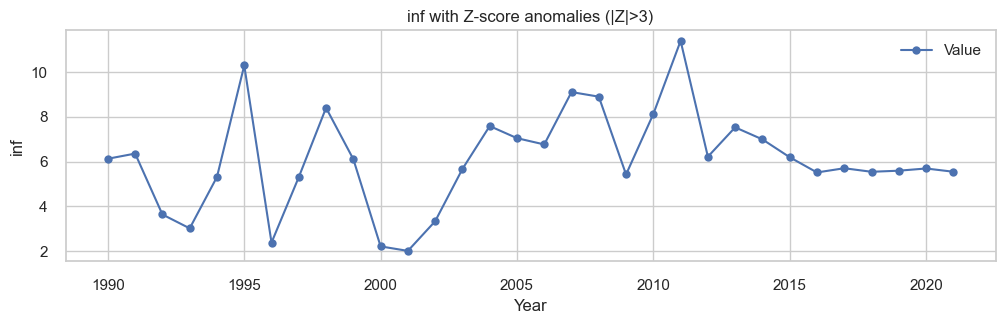

No anomalies detected by Z-score for this series.

--- Z-Score anomalies for fdi ---


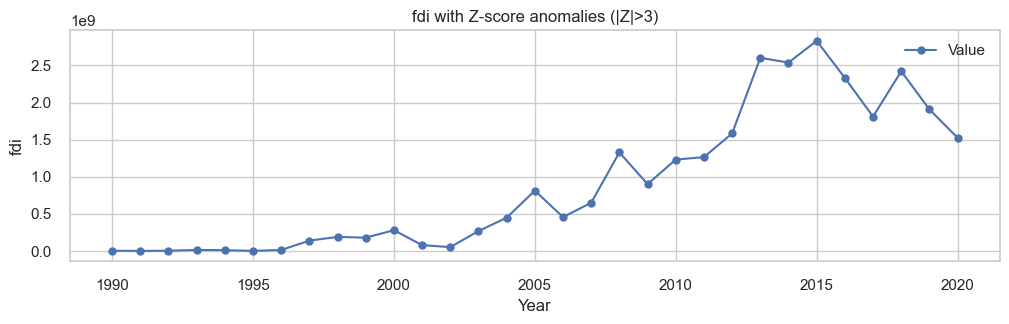

No anomalies detected by Z-score for this series.

--- Z-Score anomalies for gdp ---


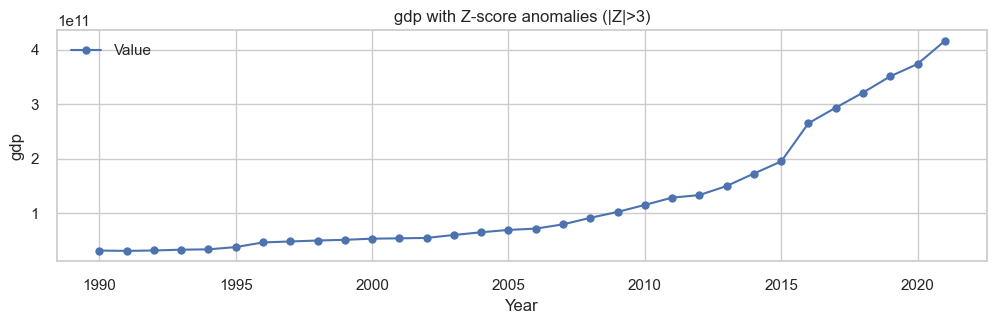

No anomalies detected by Z-score for this series.


In [22]:
zscore_results = {}   # store anomalies per series
zscore_series = {}    # store zscore series for plotting if wanted

for col in series_cols:
    print(f"\n--- Z-Score anomalies for {col} ---")
    s = df[col]
    anomalies, z = detect_zscore_anomalies(s, threshold=3.0)
    zscore_results[col] = anomalies
    zscore_series[col] = z
    # Plot
    plot_series_with_anomalies(s.index.to_numpy(), s, anomalies_idx=s.index.get_indexer(anomalies['year'].values), 
                               title=f"{col} with Z-score anomalies (|Z|>3)", ylabel=col)
    # Show anomaly table or note none
    if len(anomalies) > 0:
        display(anomalies[['year','value','zscore']])
    else:
        print("No anomalies detected by Z-score for this series.")


## 2.2 B — Isolation Forest Method

For each series: fit IsolationForest (contamination=0.1, random_state=42), mark anomalies, plot, and list anomaly years/values.



--- Isolation Forest anomalies for ggdp ---


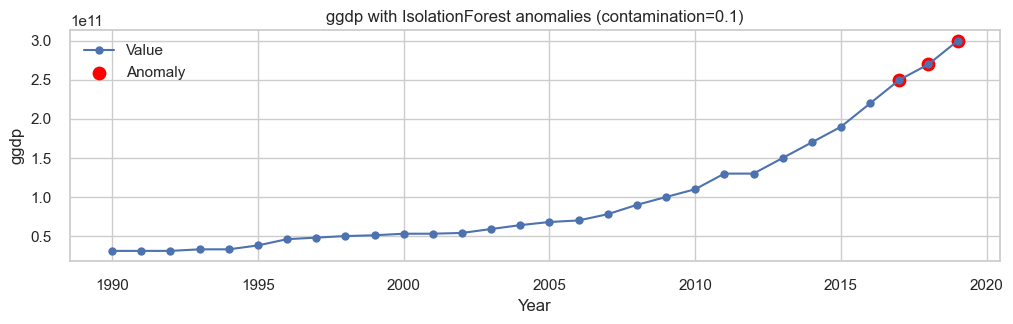

,year,value
year,,
2017,2017,2.500000e+11
2018,2018,2.700000e+11
2019,2019,3.000000e+11



--- Isolation Forest anomalies for mil ---


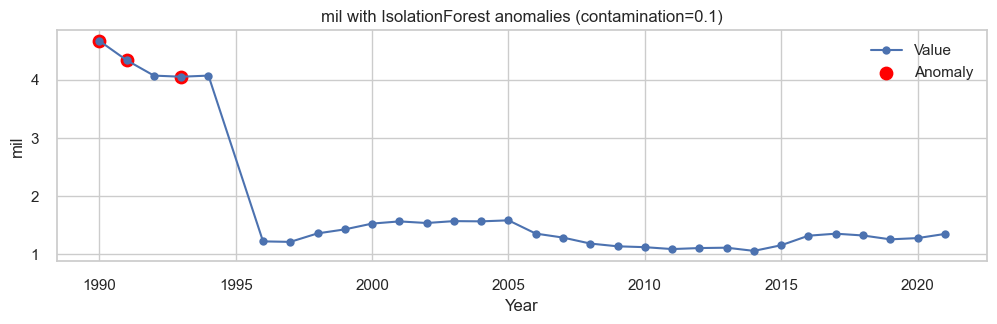

,year,value
year,,
1990,1990,4.671441
1991,1991,4.338775
1993,1993,4.055054



--- Isolation Forest anomalies for inf ---


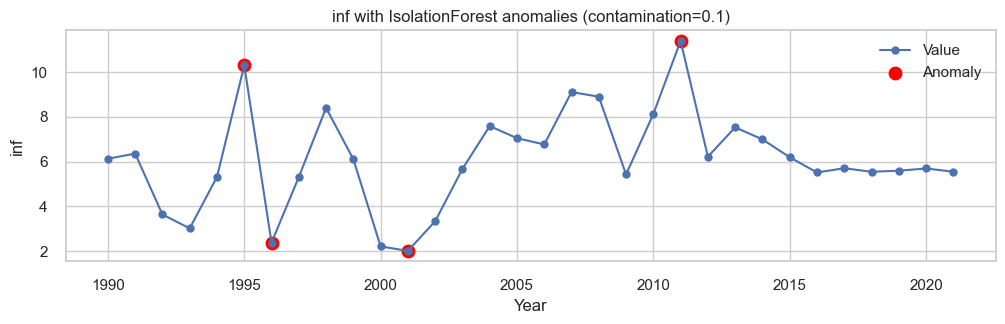

,year,value
year,,
1995,1995,10.297812
1996,1996,2.377129
2001,2001,2.007174
2011,2011,11.395165



--- Isolation Forest anomalies for fdi ---


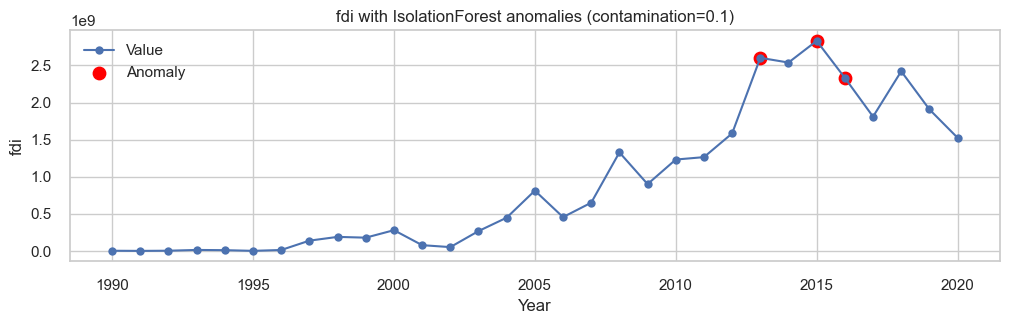

,year,value
year,,
2013,2013,2.602962e+09
2015,2015,2.831153e+09
2016,2016,2.332725e+09



--- Isolation Forest anomalies for gdp ---


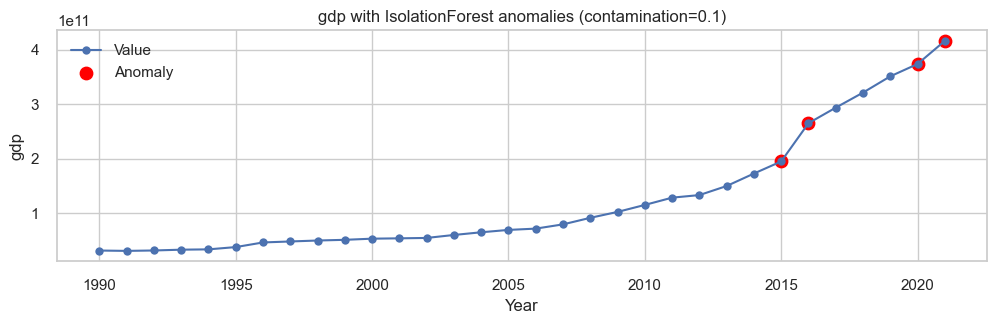

,year,value
year,,
2015,2015,195079000000
2016,2016,265236000000
2020,2020,373902000000
2021,2021,416265000000


In [23]:
ifr_results = {}

for col in series_cols:
    print(f"\n--- Isolation Forest anomalies for {col} ---")
    s = df[col]
    anomalies_if, preds, scaler = detect_isolation_forest(s, contamination=0.1, random_state=RANDOM_STATE)
    ifr_results[col] = {'anomalies': anomalies_if, 'preds': preds}
    # Plot
    # compute mask indices in full s index
    s_nonnull = s.dropna()
    mask = s_nonnull.index.get_indexer(anomalies_if['year'].values)
    plot_series_with_anomalies(s_nonnull.index.to_numpy(), s_nonnull, anomalies_idx=mask,
                               title=f"{col} with IsolationForest anomalies (contamination=0.1)", ylabel=col)
    if len(anomalies_if) > 0:
        display(anomalies_if[['year','value']])
    else:
        print("No anomalies detected by IsolationForest for this series.")


### Comment (for each series)
- After running the above, write 1–3 sentences comparing Z-score vs IsolationForest results for this variable: 
  - Are anomalies overlapping? 
  - Are some points detected only by one method?
  - Could outliers be due to measurement error or real economic shocks?
(Insert your comments below each variable's results in the notebook.)


## 2.3 Change Point Detection

We detect structural breaks using `ruptures`. We will apply:
- PELT algorithm with `model='rbf'` and a penalty (pen), and
- Optionally Binseg with a small number of breakpoints (n_bkps).



--- Change points for ggdp ---


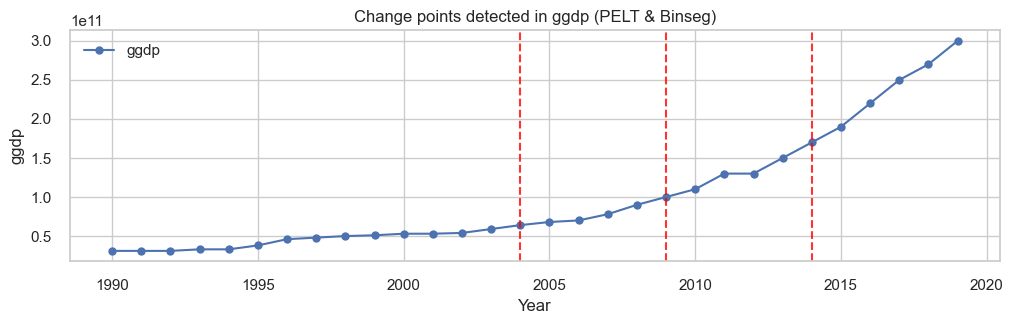

Detected change years: [2004, 2009, 2014]

--- Change points for mil ---


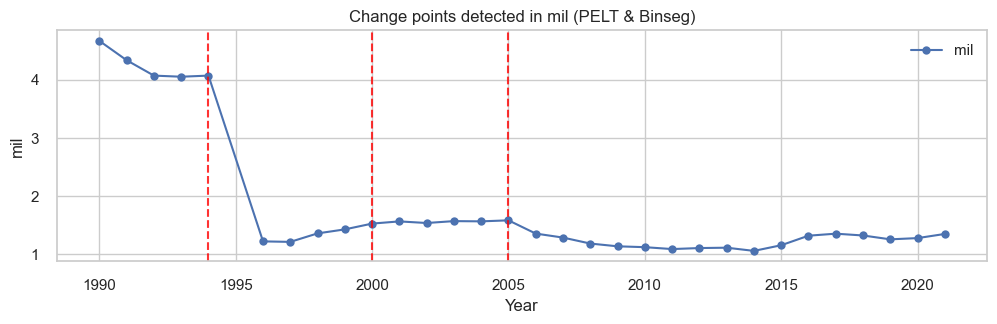

Detected change years: [1994, 2000, 2005]

--- Change points for inf ---


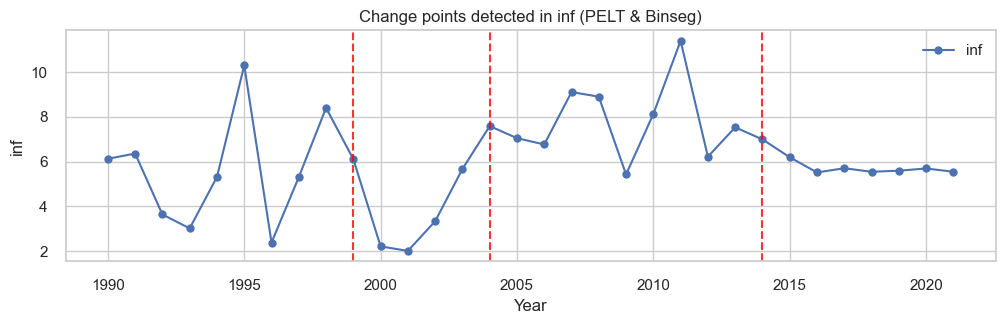

Detected change years: [1999, 2004, 2014]

--- Change points for fdi ---


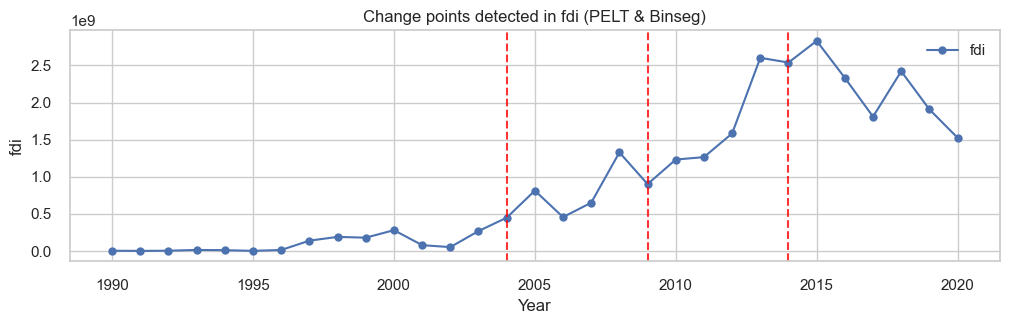

Detected change years: [2004, 2009, 2014]

--- Change points for gdp ---


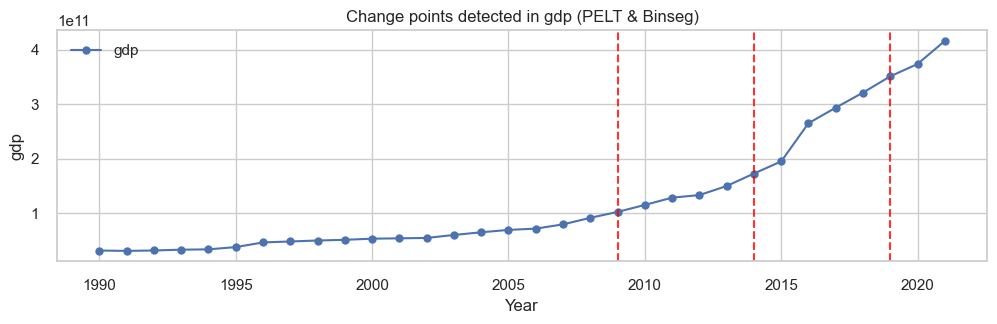

Detected change years: [2009, 2014, 2019]


In [24]:
cp_results = {}

if not has_ruptures:
    print("ruptures not installed — skipping change point detection. Install with `pip install ruptures`.")
else:
    for col in series_cols:
        print(f"\n--- Change points for {col} ---")
        s = df[col].dropna()
        if len(s) < 10:
            print("Series too short for reliable change point detection (len < 10). Skipping.")
            cp_results[col] = []
            continue
        # Try two variants: PELT with penalty, and Binseg with n_bkps = 3
        try:
            # PELT with some default penalty (tune if needed)
            change_years_pelt = detect_change_points(s, model='rbf', pen=10, n_bkps=None)
        except Exception as e:
            change_years_pelt = []
        try:
            bkps = 3
            algo = rpt.Binseg(model='l2').fit(s.values)
            bkps_binseg = algo.predict(n_bkps=bkps)
            years_binseg = [s.index[b-1] for b in bkps_binseg if 1 <= b <= len(s)]
            if years_binseg and years_binseg[-1] == s.index[-1]:
                years_binseg = years_binseg[:-1]
        except Exception as e:
            years_binseg = []
        # merge results (unique)
        cp_years = sorted(set(change_years_pelt + years_binseg))
        cp_results[col] = cp_years
        # plot with vertical lines
        plt.figure(figsize=(12,3))
        plt.plot(s.index, s.values, marker='o', label=col)
        for y in cp_years:
            plt.axvline(x=y, color='red', linestyle='--', alpha=0.8)
        plt.title(f"Change points detected in {col} (PELT & Binseg)")
        plt.xlabel("Year"); plt.ylabel(col)
        plt.legend(); plt.show()
        print("Detected change years:", cp_years)


### Comment (for each series)
- Write 1–3 sentences interpreting detected change points. Suggest plausible economic reasons or note if results may be artefacts of missing data.


In [25]:
# Build summary table: for each series, show zscore anomalies years, IF anomalies years, change points
summary = []
for col in series_cols:
    z_an = list(zscore_results.get(col, pd.DataFrame()).get('year', []).tolist())
    if_an = list(ifr_results.get(col, {}).get('anomalies', pd.DataFrame()).get('year', []).tolist()) if col in ifr_results else []
    cp = cp_results.get(col, []) if has_ruptures else []
    summary.append({
        'series': col,
        'zscore_anomalies': z_an,
        'isoforest_anomalies': if_an,
        'change_points': cp
    })
summary_df = pd.DataFrame(summary)
display(summary_df)
# Save summary for later use
summary_df.to_csv("part2_anomaly_change_summary.csv", index=False)
print("Saved part2_anomaly_change_summary.csv")


,series,zscore_anomalies,isoforest_anomalies,change_points
0,ggdp,[],"[2017, 2018, 2019]","[2004, 2009, 2014]"
1,mil,[],"[1990, 1991, 1993]","[1994, 2000, 2005]"
2,inf,[],"[1995, 1996, 2001, 2011]","[1999, 2004, 2014]"
3,fdi,[],"[2013, 2015, 2016]","[2004, 2009, 2014]"
4,gdp,[],"[2015, 2016, 2020, 2021]","[2009, 2014, 2019]"


Saved part2_anomaly_change_summary.csv


## 2.4 Summary and Discussion

- Summarize findings: list key anomalies and change points per variable; propose brief hypotheses linking them to historical events (e.g., global financial crisis, commodity shocks, policy changes).
- Compare robustness: Z-score is simplistic and may miss context; IsolationForest is more flexible; change-point finds regime changes rather than single outliers.
- Limitations: short sample length (1990–2021), missing values in ggdp/fdi/gdp for recent years, differing scales (ggdp/gdp vs mil/inf), and choice of thresholds/contamination/penalty affects results.


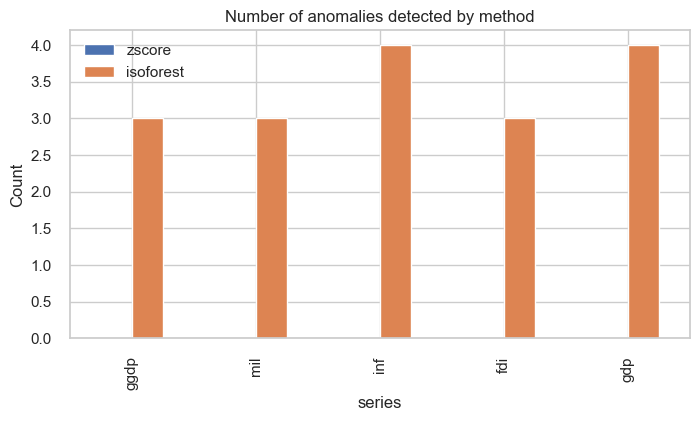

In [26]:
# Simple bar chart of counts of detected anomalies by method
counts = []
for col in series_cols:
    zr = len(zscore_results.get(col, pd.DataFrame()))
    ir = len(ifr_results.get(col, {}).get('anomalies', pd.DataFrame()))
    counts.append({'series':col, 'zscore':zr, 'isoforest':ir})
counts_df = pd.DataFrame(counts).set_index('series')
counts_df.plot.bar(figsize=(8,4))
plt.title("Number of anomalies detected by method")
plt.ylabel("Count")
plt.show()


## Final notes & next steps

- Add short written interpretations for each variable under the results cells (1–3 sentences each).
- If you have domain knowledge (policy changes, shocks), map detected anomalies/change points to real events.
- Consider alternative anomaly thresholds (Z=2.5) or lower `contamination` in IsolationForest, and tune `pen` or `n_bkps` in ruptures for sensitivity analysis.
- If multiple countries are present in a dataset, wrap detection in a loop for each country and save combined summary table.
